In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer

torch.random.manual_seed(0)
np.random.seed(0)

# Choose task a or b
task = 'b'

### Dataset

In [33]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [34]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        # Convolution and maxpooling layer 1: 32x32 -> 16x16
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (5, 5), stride = (1, 1), padding = (2, 2)), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        # Convolution and maxpooling layer 2: 16x16 -> 8x8
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        # Convolution and maxpooling layer 3: 8x8 -> 4x4
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(128*4*4, 64), # 128 outputs from last convolution, each of 4x4 size, flattened
        nn.ReLU(),
        nn.Linear(64, 10)
        # No need to include softmax, as this is already combined in the loss function
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [35]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [36]:
# Hyperparameters
learning_rate = .02
num_epochs = 5

# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()


### Train model with SGD optimizer

In [37]:
# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)
trainer_SGD = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict_SGD, test_loss_dict_SGD = trainer_SGD.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:17<00:00, 53.56it/s]


### Train model with the Adam Optimizer (task 2b)

In [38]:
if task == 'b':
  learning_rate = .001
  optimizer = torch.optim.Adam(model.parameters(),
                              lr=learning_rate)
  trainer_adam = Trainer(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    batch_size=batch_size,
    loss_function=loss_function,
    optimizer=optimizer
  )
  train_loss_dict_adam, test_loss_dict_adam = trainer_adam.train(num_epochs)

Training epoch 4: 100%|██████████| 937/937 [00:20<00:00, 45.58it/s]


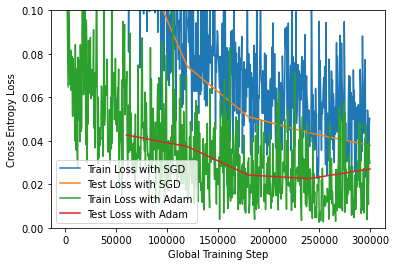

Final Test loss: 0.027065105435948606. Final Test accuracy: 0.9901


In [39]:
# We can now plot the training loss with our utility script

# Plot loss for both SGD and Adam optimizers
utils.plot_loss(train_loss_dict_SGD, label="Train Loss with SGD")
utils.plot_loss(test_loss_dict_SGD, label="Test Loss with SGD")
plt.ylim([0, 0.5])


if task == 'b':
    utils.plot_loss(train_loss_dict_adam, label="Train Loss with Adam")
    utils.plot_loss(test_loss_dict_adam, label="Test Loss with Adam")
    plt.ylim([0, 0.1])

plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")